In [15]:
#Prueba que las siguientes librerias estén disponibles

import cobra.test
import cplex # usaremos el cluster UTEM
import pandas as pd
import numpy as np
import escher
from escher import Builder

In [16]:
# Load fpkm data and model
#transcriptomic for e.coli in sheets: Ishii, Holm, Rintalta 
#wget -O S2.xls 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0157101.s002'

data=pd.read_excel("S2.xls",sheet_name="Transcriptomic data - Holm", index_col=0, header=0) 
model = cobra.test.create_test_model("ecoli")

In [17]:
model

Name,iJO1366
Memory address,0x07f66195f3610
Number of metabolites,1805
Number of reactions,2583
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [125]:
# Define una función para cargar los fpkm de acuerdo a las gene_reaction_rules

def getG(grl,fpkm):
    grl=grl.replace("(","")
    grl=grl.replace(")","")
    g = 0
    for subrule in grl.split("or"):
        g_subrule = []
        for gene in subrule.split("and"):
            gene = gene.replace(" ","")
            if gene in fpkm:
                g_subrule.append( float(fpkm[gene]) )
        if len(g_subrule)>=1: 
            g += min(g_subrule)
    return(g)

In [153]:
# Create a dictionary with the fpkm of each gene

fpkm={}

for gene in model.genes:
    if gene.id  in data.index:
        fpkm[gene] = data["Ref"].loc[gene.id]
    #else:
    #    print(gene.id," not found")
#len(fpkm)

In [154]:
# Create a dictionary with the fpkm for each reaction
g = {}
mean_g = np.mean(list(fpkm.values()) ) # useful when not a grl available

for reaction in model.reactions:
    if reaction.gene_reaction_rule == "":
        g[reaction.id] = mean_g    
    else:
        g[reaction.id] = getG(reaction.gene_reaction_rule,fpkm)
        
#g.values()


In [155]:
#1 Define objecive function
model = cobra.test.create_test_model("ecoli")

for i, reaction in enumerate(model.reactions):
    if i == 0:
        dotProduct_expression  = model.reactions.get_by_id(reaction.id).forward_variable*g[reaction.id]
        dotProduct_expression += model.reactions.get_by_id(reaction.id).reverse_variable*g[reaction.id]
    else:
        dotProduct_expression += model.reactions.get_by_id(reaction.id).forward_variable*g[reaction.id]
        dotProduct_expression += model.reactions.get_by_id(reaction.id).reverse_variable*g[reaction.id]

In [156]:
dotProduct_objective = model.problem.Objective(dotProduct_expression,direction="min")
model.objective = dotProduct_objective 


In [166]:
#Fijación de glucosa
model.reactions.get_by_id("EX_glc__D_e").bounds=(-9.2,-9.2)
model.reactions.get_by_id("EX_glc__D_e").bounds

(-9.2, -9.2)

In [167]:
#2.3 Compute new distribution of fluxes
solution_SPOT = model.optimize()

In [168]:
import escher
from escher import Builder
builder=Builder(
    map_name="e_coli_core.Core metabolism",
    model_name="e_coli_core",
)
builder.reaction_data=solution_SPOT.fluxes
builder

Builder(reaction_data={'DM_4crsol_c': -0.0, 'DM_5drib_c': -0.0, 'DM_aacald_c': 0.0, 'DM_amob_c': -0.0, 'DM_mth…

In [169]:
#builder.reaction_data

In [170]:
#fpkm.values()

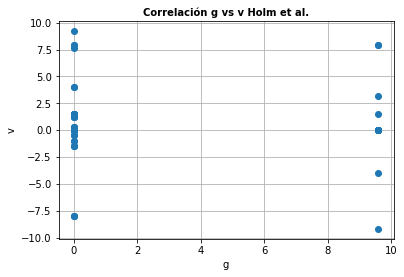

In [171]:
import numpy as np
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt

#Definiendo ejes

x=g.values()
y=solution_SPOT.fluxes
#Etiquetas de titulo y ejes
plt.plot(x, y.values[0:], 'o')

plt.title('Correlación g vs v Holm et al.',fontsize = 10,fontweight = "bold")
plt.xlabel('g')
plt.ylabel('v')


plt.grid()
plt.show()

In [172]:
flujos=["GLCptspp",'PGI','FBA','TPI',"GAPD","PYK","PGL","GND","RPE","RPI","TKT1","TKT2","TALA","CS","ACONTa","ICDHyr","PDH","ME1","PPC","PTAr"]
#valores EXPERIMENTALES isshi
flux_ex={'GLCptspp':11.7,'PGI':6.8,'FBA':9.6,'TPI':9.6,'GAPD':20.4,
         'PYK':4.9,'PGL':4.9,'GND':4.9,'RPE':2.8,'RPI':2.1,
     'TKT1':1.5,'TKT2':1.3,'TALA':1.5,'CS':5.6,'ACONTa':5.6,
         'ICDHyr':5.6,'PDH':15,'ME1':0.2,'PPC':4,'PTAr':7.9}

In [173]:
flux_pr=[]
flux_exl=[]
for i in flujos:    
    model.reactions.get_by_id(i)
    #print (model.reactions.get_by_id(i), model.reactions.get_by_id(i).name)
    print (i,'|',solution_SPOT[i],'|',flux_ex[i])
    flux_exl.append(flux_ex[i])
    flux_pr.append(solution_SPOT[i])

GLCptspp | 0.0 | 11.7
PGI | 0.0 | 6.8
FBA | 0.24948453608247417 | 9.6
TPI | 0.24948453608247417 | 9.6
GAPD | 0.0 | 20.4
PYK | 0.0 | 4.9
PGL | 0.0 | 4.9
GND | 0.0 | 4.9
RPE | -0.9979381443298967 | 2.8
RPI | -0.9979381443298967 | 2.1
TKT1 | -0.49896907216494835 | 1.5
TKT2 | -0.4989690721649483 | 1.3
TALA | -0.4989690721649483 | 1.5
CS | 0.0 | 5.6
ACONTa | 0.0 | 5.6
ICDHyr | 0.0 | 5.6
PDH | 0.0 | 15
ME1 | 0.0 | 0.2
PPC | 0.0 | 4
PTAr | 0.0 | 7.9


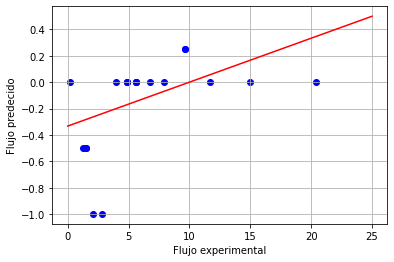

In [174]:
x=flux_exl
y=flux_pr

plt.scatter(x,y,c="blue")
plt.xlabel('Flujo experimental')
plt.ylabel('Flujo predecido')

#Agregar Linea de tendencia por medio de Minimos Cuadrados Ordinarios 
m=np.array([np.ones(20),x]).T #Para ejecutar de forma correcta la ec. Beta es necesario agregar una columna de 1 en el eje X
B=np.linalg.inv(m.T @m) @ m.T @y #ec. beta para realizar la linea de tendencia

plt.plot([0,25],[B[0]+B[1]*1,B[0]+B[1]*25],c="red") # Linea de tendencia

plt.grid()
plt.show()